# Paper Figures

---
# Setup

## Modules

In [1]:
import os
from Bio import Phylo, AlignIO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
import scipy
import math
import numpy as np
import geopandas
import datetime
import shapely
import copy

## Paths

In [2]:
project_dir = "/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/"

# ------------------------------------------
# Full Dataset
divtree_path        = project_dir + "iqtree/all/chromosome/full/filter5/iqtree.filter.nwk"
timetree_path       = project_dir + "lsd/all/chromosome/full/filter5/lsd.nex"
metadata_path       = project_dir + "snippy_multi/all/chromosome/full/metadata.tsv"
constant_sites_path = project_dir + "snippy_multi/all/chromosome/full/snippy-multi.constant_sites.txt"
aln_path            = project_dir + "lsd/all/chromosome/full/filter5/lsd.filter.aln"
latlon_path         = project_dir + "beast2/all/chromosome/full/filter5/beast.latlon.txt"

## Variables

In [3]:
CURRENT_YEAR = datetime.datetime.utcnow().year

# Sequence length
with open(constant_sites_path) as infile:
    data = infile.read().strip().split(",")
    constant_sites = sum([int(count) for count in data])

aln = AlignIO.read(aln_path, "fasta")
variant_sites = len(aln[0].seq)

SEQ_LEN = constant_sites + variant_sites

# Geo
CRS = "epsg:4326"
world_polygons = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# Reference
REF_DATE_BP = CURRENT_YEAR - 1992
REF_BRANCH_MAJOR = "1.ORI"
REF_BRANCH_MINOR = "1.ORI1"

# Plotting
SM_FONT = 4
MED_FONT = 6
LG_FONT = 8
D3_PAL = ["#1f77b4", "#ff7f0e" ]
"""1f77b4 #1f77b4
ff7f0e #ff7f0e
2ca02c #2ca02c
d62728 #d62728
9467bd #9467bd
8c564b #8c564b
e377c2 #e377c2
7f7f7f #7f7f7f
bcbd22 #bcbd22
17becf #17becf"""

'1f77b4 #1f77b4\nff7f0e #ff7f0e\n2ca02c #2ca02c\nd62728 #d62728\n9467bd #9467bd\n8c564b #8c564b\ne377c2 #e377c2\n7f7f7f #7f7f7f\nbcbd22 #bcbd22\n17becf #17becf'

## Import Trees

In [4]:
# Divtree
divtree = Phylo.read(divtree_path, "newick")
divtree.ladderize(reverse=False)

# Timetree
trees = Phylo.parse(timetree_path, "newick")
for tree in trees:
    clades = [c for c in tree.find_clades()]
    if len(clades) > 1:
        break
timetree = tree
timetree.ladderize(reverse=False)

## Import Metadata

In [5]:
metadata_df = pd.read_csv(metadata_path, sep='\t')
metadata_df.set_index(metadata_df.columns[0], inplace=True)
metadata_copy_df = copy.deepcopy(metadata_df)

latlon_df = pd.read_csv(latlon_path, sep='\t')
latlon_df.set_index(latlon_df.columns[0], inplace=True)

for sample in metadata_df.index:
    if sample not in latlon_df.index:
        metadata_copy_df.drop(sample, inplace=True)

# Add reference
metadata_copy_df.at["Reference", "strain"] = "CO92"

# Fix NA
metadata_copy_df.fillna("NA", inplace=True)

geometry = []

for rec in latlon_df.iterrows():
    sample = rec[0]
    lat = rec[1]["lat"]
    lon = rec[1]["lon"]
    metadata_copy_df.at[sample, "geometry_lat"] = lat
    metadata_copy_df.at[sample, "geometry_lon"] = lon
    point = shapely.geometry.Point(lon,lat)
    geometry.append(point)

metadata_gdf = geopandas.GeoDataFrame(metadata_copy_df, crs=CRS, geometry=geometry)

display(metadata_gdf)

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,geometry_lat,geometry_lon,geometry
sample,,,,,,,,,,,,,,,,,,,
GCA_009909635.1_ASM990963v1_genomic,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,47.622245,40.795794,POINT (-105.60772 38.72518)
GCA_009669545.1_ASM966954v1_genomic,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,42.480495,85.463346,POINT (40.79579 47.62225)
GCA_009669555.1_ASM966955v1_genomic,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,42.480495,85.463346,POINT (85.46335 42.48050)
GCA_009669565.1_ASM966956v1_genomic,42118,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,42.480495,85.463346,POINT (85.46335 42.48050)
GCA_009669605.1_ASM966960v1_genomic,42117,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722922,KEEP: Assembly Modern,0,Asia,42.480495,85.463346,POINT (85.46335 42.48050)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA7313246_49,Gdansk8,[1400:1700],[-621:-321],Poland,Pomeranian Voivodeship,52.2159,19.1344,54.2456,18.1099,Second Pandemic,1.PRE,1.PRE1,SAMEA7313246_49,KEEP: SRA Ancient Combined Record,1,Europe,54.245560,18.109900,POINT (40.79579 47.62225)
SAMEA6651390,AGU010,[1435:1477],[-586:-544],Lithuania,Vilnius County,55.35,23.75,54.8227,25.2495,Second Pandemic,1.PRE,1.PRE1,SAMEA6651390,KEEP: SRA Ancient,1,Europe,54.822692,25.249534,POINT (18.10990 54.24556)
SAMEA6637004,AGU025,[1441:1612],[-580:-409],Lithuania,Vilnius County,55.35,23.75,54.8227,25.2495,Second Pandemic,1.PRE,1.PRE1,SAMEA6637004,KEEP: SRA Ancient,1,Europe,54.822692,25.249534,POINT (25.24953 54.82269)


# Colors

Use the full tree for color order

In [6]:
# Colors
attr_states = list(dict.fromkeys(metadata_gdf["branch_major"]))
# Create the custom color map (pyplot)
cmap = plt.get_cmap("rainbow", len(attr_states))
# Convert the color map to a list of RGB values
cmaplist = [cmap(i) for i in range(cmap.N)]
# Convert RGB values to hex colors
attr_hex = [colors.to_hex(col) for col in cmaplist]
colors_dict = {}

# Assign states colors based on tip order
i_hex = 0
for c in divtree.get_terminals():
    if c.name == "Reference":
        branch = "1.ORI"
    else:
        branch = metadata_gdf["branch_major"][c.name]
    if branch not in colors_dict:
        colors_dict[branch] = attr_hex[i_hex]
        i_hex += 1
        
print(colors_dict)

{'0.PRE': '#8000ff', '0.PE': '#5148fc', '0.ANT': '#238af5', '3.ANT': '#0cc1e8', '4.ANT': '#3ae8d7', '2.ANT': '#68fcc1', '2.MED': '#97fca7', '1.PRE': '#c5e88a', '1.ANT': '#f3c16a', '1.IN': '#ff8a48', '1.ORI': '#ff4824'}


---
# Functions

## Plot RTT

In [7]:
def plot_rtt(df, fig, ax):
    """
    Plot root to tip distances.
    """
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df["date_mean"],df["rtt_dist"])
    r2 = r_value * r_value    
    y_intercept = CURRENT_YEAR - (0 - intercept)/slope
    p_sig = ""
    p_thresh = 0.05    
    if p_value < p_thresh:
        p_sig = "*"
        
    mut_per_year = SEQ_LEN * slope
    year_per_mut = 1 / mut_per_year
        
        
    sns.regplot(
        ax=ax,
        data=df, 
        x="date_mean", 
        y="rtt_dist", 
        #robust=True,
        ci=95,
        scatter_kws={"s": 0},
        color="grey",
        label=(
        "   R2: {}".format(round(r2,2))
        + "\n     p: {:.2e}{}".format(p_value, p_sig)
        + "\nRate: {:.2} +/ {:.2}".format(slope, std_err)  
        + "\n         {} years/substitution".format(round(year_per_mut))
        + "\nRoot: {} YBP".format(round(y_intercept))                
        )
    )
    
    plt.errorbar(
        data=df, 
        x="date_mean",
        y="rtt_dist", 
        xerr="date_err",
        yerr=None,
        ls='none',
        c = df["branch_major_color"][0],  
        capsize=1,
        label=None,
        zorder=1,
        )  
    
    sns.scatterplot(
        ax=ax,
        data=df, 
        x="date_mean",
        s=10,
        y="rtt_dist", 
        c = df["branch_major_color"], 
        ec = "black",
        alpha=0.75,
        zorder=2,
    )
    
    ax.set_xlabel("Date")
    ax.set_ylabel("")
    ax.set_title(label)
    xlim = ax.get_xlim()
    x_buff = round((xlim[1] - xlim[0]) * 0.1,1)
    new_xlim = [xlim[0]-x_buff, xlim[1]+x_buff]
    if new_xlim[1] > CURRENT_YEAR:
        new_xlim = [new_xlim[0], CURRENT_YEAR]
    ax.set_xlim(new_xlim)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))  
    
    legend = ax.legend(borderpad=0.8, handletextpad=-2, bbox_to_anchor=(0.5, -0.55), loc='center')
    frame = legend.get_frame()
    frame.set_edgecolor("black")
    frame.set_linewidth(0.5)
    
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)

## Get X and Y Positions

In [8]:
def get_x_positions(tree):
    """Create a mapping of each clade to its horizontal position.
    Dict of {clade: x-coord}
    """
    depths = tree.depths()
    # If there are no branch lengths, assume unit branch lengths
    if not max(depths.values()):
        depths = tree.depths(unit_branch_lengths=True)
    return depths


# This code is from the biopython Phylo module
def get_y_positions(tree):
    """Create a mapping of each clade to its vertical position.
    Dict of {clade: y-coord}.
    Coordinates are negative, and integers for tips.
    """
    maxheight = tree.count_terminals()
    # Rows are defined by the tips
    heights = {
        tip: maxheight - i for i, tip in enumerate(reversed(tree.get_terminals()))
    }

    # Internal nodes: place at midpoint of children
    def calc_row(clade):
        for subclade in clade:
            if subclade not in heights:
                calc_row(subclade)
        # Closure over heights
        heights[clade] = (heights[clade.clades[0]] + heights[clade.clades[-1]]) / 2.0

    if tree.root.clades:
        calc_row(tree.root)
    return heights

## Parse Nexus Comment

In [9]:
## Parse Comment

def parse_comment(comment):
    """
    Parse nexus comment into dict
    """
    comment_dict = {}
    comment = comment.lstrip("&").replace('"','')
    attr_name = ""
    attr_val = ""
    comment_sep = ","
    attr_sep = "="
    
    parsing_name = True
    parsing_val = False

    for i in range(0, len(comment)):
        
        # Parsing attribute names
        if parsing_name:
            if comment[i] != attr_sep:    
                attr_name += comment[i] 
            else:
                comment_dict[attr_name] = ""
                parsing_name = False
                parsing_val = True
            
        elif parsing_val:
            if comment[i] == comment_sep:
                # The val does not contain an interval, truly the end
                if "{" not in attr_val or ("{" in attr_val and "}" in attr_val):
                    comment_dict[attr_name] = attr_val
                    attr_val = ""
                    attr_name = ""
                    parsing_val = False
                    parsing_name = True
                else:
                    attr_val += comment[i]
            elif i == len(comment) - 1:
                attr_val += comment[i]                
                comment_dict[attr_name] = attr_val 
            else:
                attr_val += comment[i]
                

    return(comment_dict)

## Convert Time Ticks

In [10]:
# My own conversion function
def convert_timetree_ticks(tree, step):
    """
    Return a dict of axis locations and labels for an input timetree tree.
    """
    # Step 1: Figure out offset to convert year branch length to calendar date
    if not tree.root.branch_length:
        tree.root.branch_length = 0
    min_date = tree.root.numdate - tree.root.branch_length
    max_date = np.max([n.numdate for n in tree.get_terminals()])
    offset = min_date
    date_range = max_date - min_date

    # Step 2: Relabel xticks and space them differently
    # Distance between ticks
    dtick = step
    # Minimum tick value
    min_tick = step * (offset // step)

    # Extra tick increment
    extra = dtick if dtick < date_range else dtick
    # New tick values
    tick_vals = np.arange(min_tick, min_tick + date_range + extra, dtick)
    # New tick locations
    tick_locs = list(tick_vals - offset)
    # New tick labels
    tick_labels = ["%d" % (int(x)) for x in tick_vals]
    return {"tick_locs": tick_locs, "tick_labels": tick_labels}


---
# Parse Tree Into Dataframe

In [11]:
x_posns = get_x_positions(divtree)
y_posns = get_y_positions(divtree)


for c in divtree.get_terminals():

    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    metadata_gdf.at[c.name, 'divtree_coord_x'] = coord_x
    metadata_gdf.at[c.name, 'divtree_coord_y'] = coord_y
        
    if c.name == "Reference":
        date_mean = REF_DATE_BP
        date_range = [date_mean,date_mean]
        branch_major = REF_BRANCH_MAJOR
        branch_minor = REF_BRANCH_MINOR      
    else:
        # Dates
        date = metadata_gdf["date_bp"][c.name].strip("[]").split(":")
        if len(date) == 1:
            date_mean = int(date[0])
            date_range = [date_mean,date_mean]
        else:
            date_range = [int(d) for d in date]           
            date_mean = sum(date_range)/len(date_range)
            
        # Branch
        branch_major = metadata_df["branch_major"][c.name]
        branch_minor = metadata_df["branch_minor"][c.name]
        
    # Remove letters at end
    while branch_minor[-1].isalpha():
        branch_minor = branch_minor[:-1]
    
    calendar_date = date_mean + CURRENT_YEAR
    calendar_date_lower = date_range[0] + CURRENT_YEAR
    calendar_date_upper = date_range[1] + CURRENT_YEAR
    date_err = abs(date_mean - date_range[0])
    
    rtt_dist = divtree.distance(c.name)
        
    metadata_gdf.at[c.name, "date_mean"] = calendar_date
    metadata_gdf.at[c.name, "date_err"] = date_err
    metadata_gdf.at[c.name, "date_lower"] = calendar_date_lower
    metadata_gdf.at[c.name, "date_upper"] = calendar_date_upper
    
    metadata_gdf.at[c.name, "branch_major"] = branch_major
    metadata_gdf.at[c.name, "branch_major_color"] = colors_dict[branch_major]
    metadata_gdf.at[c.name, "branch_minor"] = branch_minor
    metadata_gdf.at[c.name, "rtt_dist"] = rtt_dist

display(metadata_gdf)

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,...,geometry_lon,geometry,divtree_coord_x,divtree_coord_y,date_mean,date_err,date_lower,date_upper,branch_major_color,rtt_dist
sample,,,,,,,,,,,,,,,,,,,,,
GCA_009909635.1_ASM990963v1_genomic,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,...,40.795794,POINT (-105.60772 38.72518),0.000073,339.0,1923.0,0.0,1923.0,1923.0,#97fca7,0.000073
GCA_009669545.1_ASM966954v1_genomic,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,...,85.463346,POINT (40.79579 47.62225),0.000054,152.0,2006.0,0.0,2006.0,2006.0,#238af5,0.000054
GCA_009669555.1_ASM966955v1_genomic,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,...,85.463346,POINT (85.46335 42.48050),0.000055,171.0,2005.0,0.0,2005.0,2005.0,#238af5,0.000055
GCA_009669565.1_ASM966956v1_genomic,42118,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,...,85.463346,POINT (85.46335 42.48050),0.000055,173.0,2005.0,0.0,2005.0,2005.0,#238af5,0.000055
GCA_009669605.1_ASM966960v1_genomic,42117,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,...,85.463346,POINT (85.46335 42.48050),0.000055,165.0,2005.0,0.0,2005.0,2005.0,#238af5,0.000055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA7313246_49,Gdansk8,[1400:1700],[-621:-321],Poland,Pomeranian Voivodeship,52.2159,19.1344,54.2456,18.1099,Second Pandemic,...,18.109900,POINT (40.79579 47.62225),0.000060,423.0,1550.0,150.0,1400.0,1700.0,#c5e88a,0.000060
SAMEA6651390,AGU010,[1435:1477],[-586:-544],Lithuania,Vilnius County,55.35,23.75,54.8227,25.2495,Second Pandemic,...,25.249534,POINT (18.10990 54.24556),0.000060,420.0,1456.0,21.0,1435.0,1477.0,#c5e88a,0.000060
SAMEA6637004,AGU025,[1441:1612],[-580:-409],Lithuania,Vilnius County,55.35,23.75,54.8227,25.2495,Second Pandemic,...,25.249534,POINT (25.24953 54.82269),0.000061,422.0,1526.5,85.5,1441.0,1612.0,#c5e88a,0.000061


---
# Plot RTT

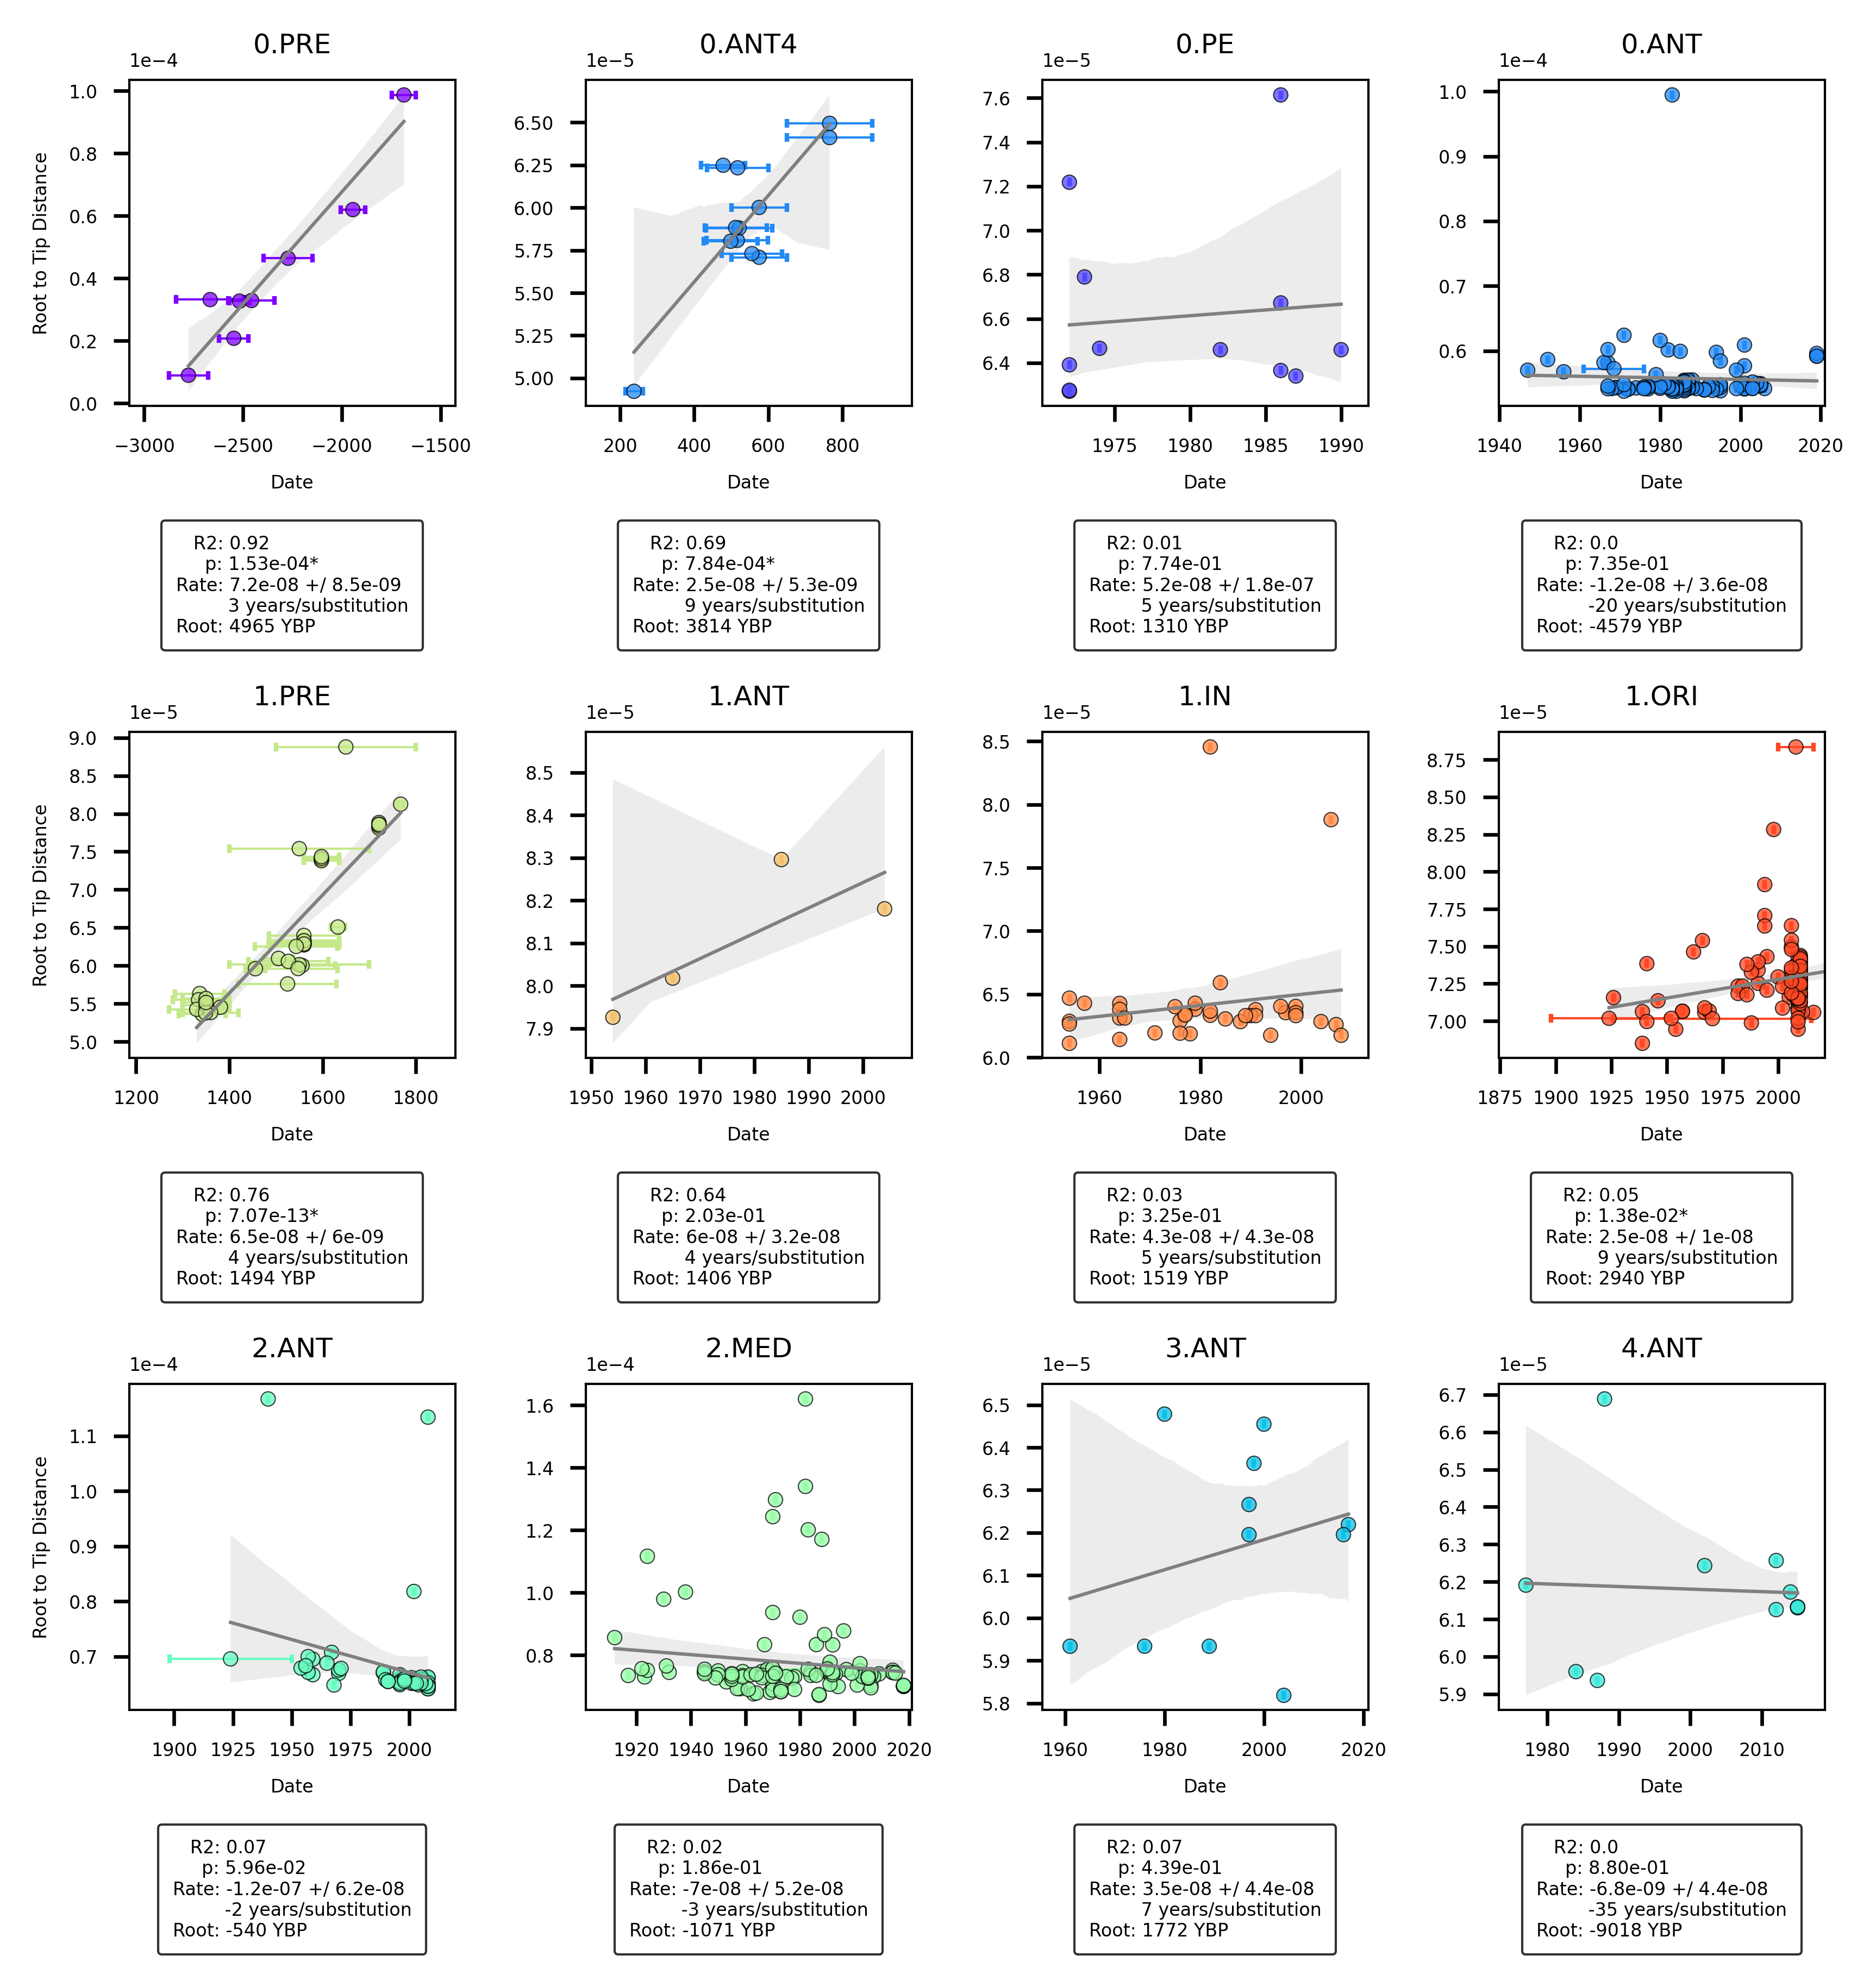

In [12]:
TARGET_RES = [480, 480]
DPI=600
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]


plt.rc("font", size=SM_FONT)  # controls default text sizes
plt.rc("lines", linewidth=0.5)
plt.rc("figure", titlesize=MED_FONT)  # fontsize of the figure title
plt.rc("legend", title_fontsize=SM_FONT)  # fontsize of the legend title
plt.rc("legend", fontsize=SM_FONT)  # fontsize of the legend title
plt.rc("legend", frameon=True)  # legend frame
plt.rc("axes", labelsize=SM_FONT)  # fontsize of the x and y labels
plt.rc("axes", titlesize=MED_FONT)  # fontsize of axis titles

fig=plt.figure(figsize=FIGSIZE, dpi=DPI) 
ax_x_buff = 1.5
ax_y_buff = 2.5
ax_scale = 5
axes = []

branch_list = {
    "0.PRE": ["0.PRE1", "0.PRE2"], 
    "0.ANT4" : ["0.ANT4"], 
    "0.PE": ["0.PE4m", "0.PE4m", "0.PE4t", "0.PE4a", "0.PE5"],   
    "0.ANT": ["0.ANT1", "0.ANT2","0.ANT3","0.ANT5"],     
}

row_x = 0
row_y = 0
ax_size = (1/len(branch_list)) * ax_scale

for label in branch_list:
    # Setup axis
    axes.append(fig.add_axes([row_x,row_y,ax_size,ax_size]))
        
    row_x += 1/len(branch_list) + ax_x_buff
    branches = branch_list[label]
    df = metadata_gdf[metadata_gdf["branch_minor"].isin(branches)]   
    plot_rtt(df=df, fig=fig, ax=axes[-1])  
    
    if row_x - (1/len(branch_list) + ax_x_buff) == 0:
        axes[-1].set_ylabel("Root to Tip Distance")
    

# ------------------------------------------------------------
# Branch 1 
branch_list = {
    "1.PRE" : ["1.PRE1", "1.PRE2", "1.PRE3"],    
    "1.ANT": ["1.ANT1"], 
    "1.IN": ["1.IN1","1.IN2","1.IN3"],   
    "1.ORI" : ["1.ORI1", "1.ORI2", "1.ORI3"]
}

row_x = 0
row_y = row_y - ax_y_buff
ax_size = (1/len(branch_list)) * ax_scale

for label in branch_list:
    # Setup axis
    axes.append(fig.add_axes([row_x,row_y,ax_size,ax_size]))
        
    row_x += 1/len(branch_list) + ax_x_buff
    branches = branch_list[label]
    df = metadata_gdf[metadata_gdf["branch_minor"].isin(branches)]   
    plot_rtt(df=df, fig=fig, ax=axes[-1])  
    
    if row_x - (1/len(branch_list) + ax_x_buff) == 0:
        axes[-1].set_ylabel("Root to Tip Distance")


# ------------------------------------------------------------
# Branch 2,3,4
branch_list = {
    "2.ANT": ["2.ANT1","2.ANT2","2.ANT3" ], 
    "2.MED": ["2.MED0", "2.MED1","2.MED2","2.MED3" ], 
    "3.ANT": ["3.ANT1", "3.ANT2" ],     
    "4.ANT": ["4.ANT1" ],           
}

row_x = 0
row_y = row_y - ax_y_buff
ax_size = (1/len(branch_list)) * ax_scale

for label in branch_list:
    # Setup axis
    axes.append(fig.add_axes([row_x,row_y,ax_size,ax_size]))
        
    row_x += 1/len(branch_list) + ax_x_buff
    branches = branch_list[label]
    df = metadata_gdf[metadata_gdf["branch_minor"].isin(branches)]   
    plot_rtt(df=df, fig=fig, ax=axes[-1])  
    
    if row_x - (1/len(branch_list) + ax_x_buff) == 0:
        axes[-1].set_ylabel("Root to Tip Distance")

out_dir = project_dir + "iqtree/all/chromosome/full/filter5/"
out_path = os.path.join(out_dir, "iqtree.filter.rtt")

plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

# Plot Map

## Prep Dataframes

In [13]:
# Marker sizes
sizes_dict = {}

for lat,lon in zip(metadata_gdf["geometry_lat"], metadata_gdf["geometry_lon"]):
    if (lat,lon) not in sizes_dict:
        sizes_dict[(lat,lon)] = 0
    sizes_dict[(lat,lon)] += 1
    
# Add size info
for rec in metadata_gdf.iterrows():
    sample = rec[0]
    lat,lon = rec[1]["geometry_lat"], rec[1]["geometry_lon"]
    metadata_gdf.at[sample, "geometry_size"] = sizes_dict[(lat,lon)]

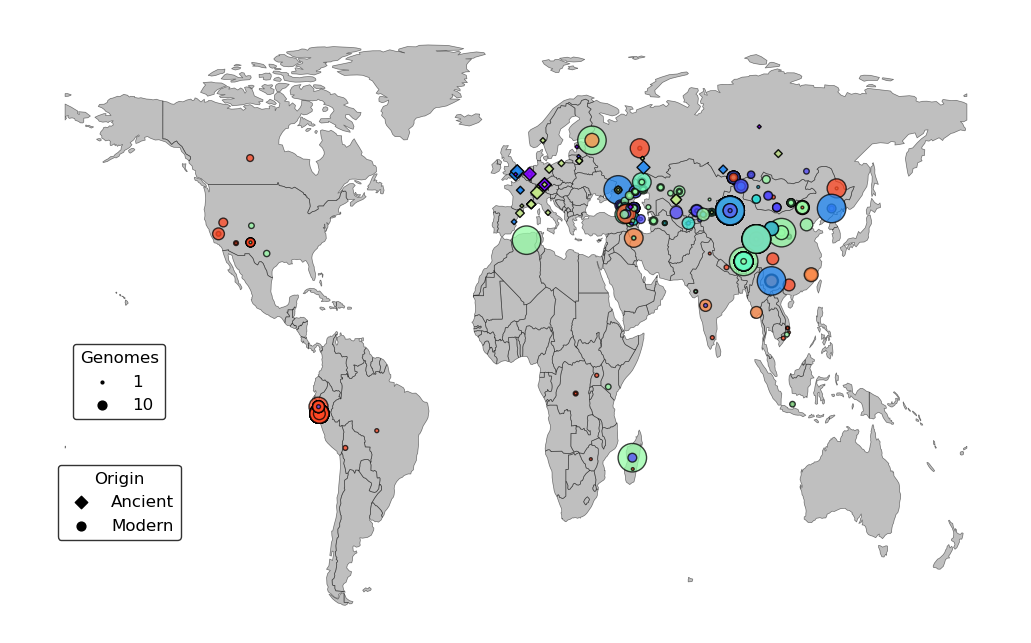

In [151]:
ancient_gdf = metadata_gdf[metadata_gdf["biosample_comment"].str.contains("Ancient")]
modern_gdf  = metadata_gdf[metadata_gdf["biosample_comment"].str.contains("Modern")]
TARGET_RES = [1280, 1280]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
plt.rc("legend", title_fontsize=MED_FONT)  # fontsize of the legend title
plt.rc("legend", fontsize=MED_FONT)  # fontsize of the legend title

fig, ax_map = plt.subplots(1, dpi=DPI, figsize=FIGSIZE)
# --------------------------------------
# World Basemap
world_poly = world_polygons.plot(
    ax=ax_map, 
    zorder=1, 
    alpha=0.5, 
    color="grey",
    edgecolor="black", 
    linewidth=0.25,
)


modern_gdf.plot(
    ax=ax_map, 
    zorder=2,
    label=None, 
    ec="black", 
    linewidth=0.5,
    markersize=modern_gdf["geometry_size"],
    #c=D3_PAL[0],
    c=modern_gdf["branch_major_color"],
    alpha=0.75)

ancient_gdf.plot(
    ax=ax_map, 
    zorder=3,
    label=None, 
    ec="black", 
    linewidth=0.5,
    markersize=ancient_gdf["geometry_size"],
    marker="D",
    #c=D3_PAL[1],    
    c=ancient_gdf["branch_major_color"],    
    alpha=0.90
)

# Origin Legend
o = [ax_map.scatter(0,-9000, s=10, ec="black", marker="D", c="black", lw=0.5),
     ax_map.scatter(0,-9000, s=10, ec="black", c="black", lw=0.5)
    ]
ol = ["Ancient", "Modern"]

leg_origin = plt.legend(o, ol, title="Origin", loc="center", bbox_to_anchor=[0.10,0.2], edgecolor="black")
leg_origin.get_frame().set_linewidth(0.5)

# Size Legend
s = [ax_map.scatter(0,-9000, s=1, ec="black", c="black", lw=0.5),
     ax_map.scatter(0,-9000, s=10, ec="black", c="black", lw=0.5),  
    ]
sl = ["1", "10"]
leg_size = plt.legend(s, sl, title="Genomes", loc="center", bbox_to_anchor=[0.10,0.4], edgecolor="black")
leg_size_frame = leg_size.get_frame()
leg_size_frame.set_linewidth(0.5)

ax_map.add_artist(leg_origin)
leg_size.get_frame().set_linewidth(0.5)


# Sorry Antarctica
ax_map.set_ylim(-60,90)
ax_map.axis('off')  

out_dir = project_dir + "lsd/all/chromosome/full/filter5/"
out_path = os.path.join(out_dir, "lsd.filter.map")

plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

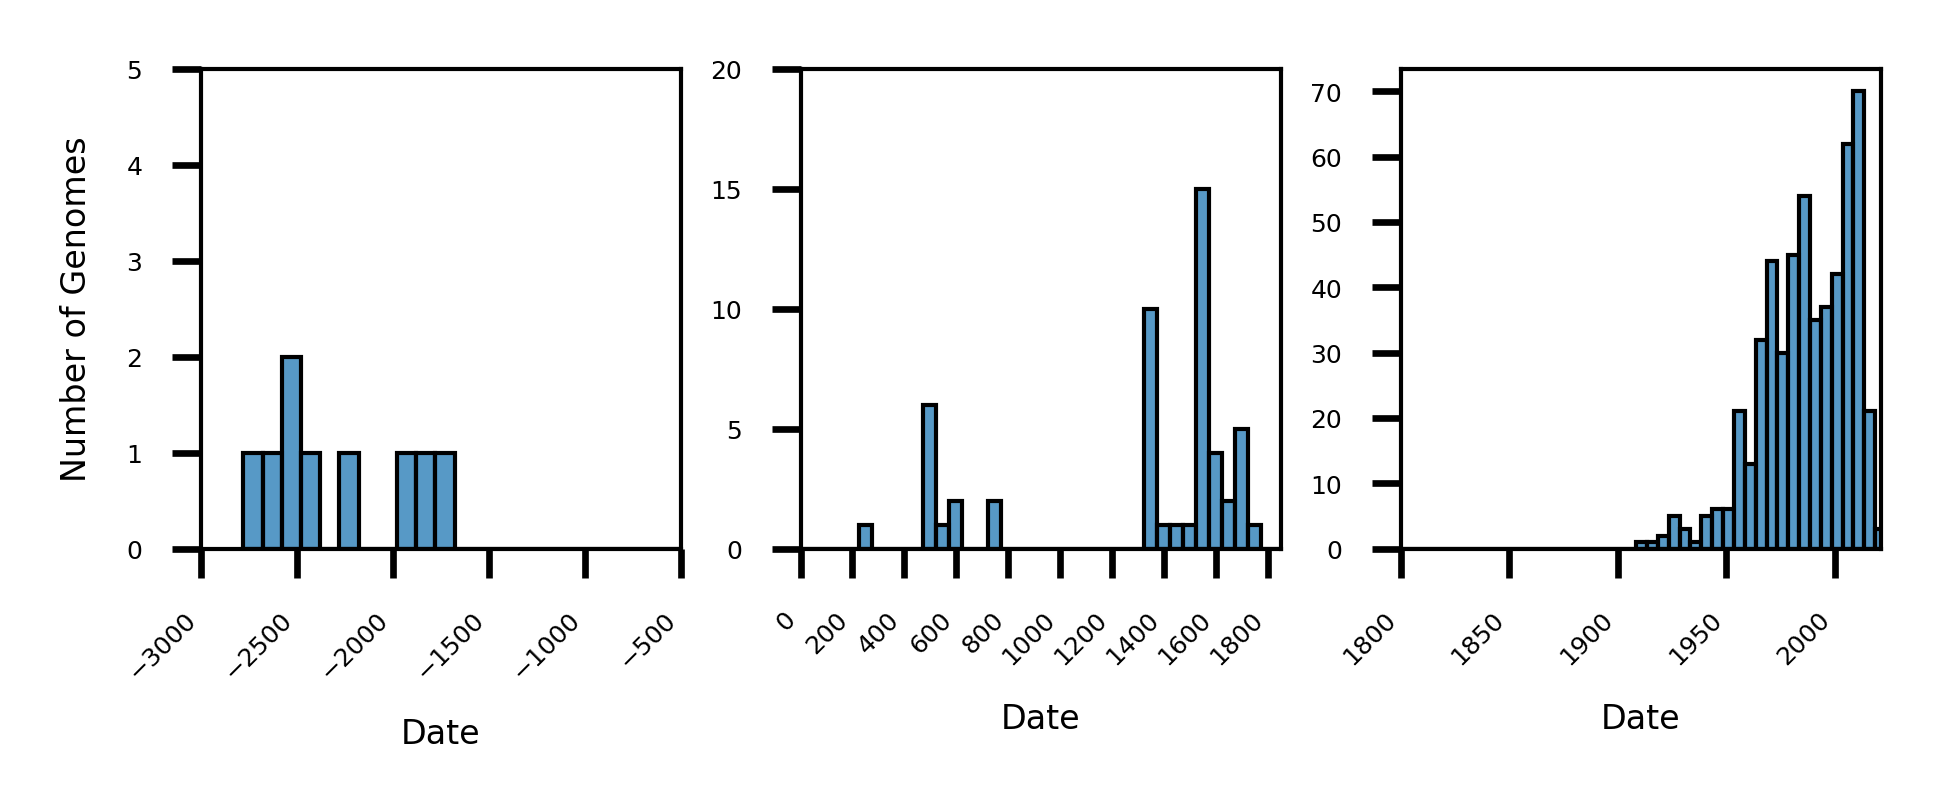

In [150]:
TARGET_RES = [480, 480]
DPI=600
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
plt.rc("font", size=3)  # controls default text sizes
plt.rc("axes",linewidth=0.5)
fig=plt.figure(figsize=FIGSIZE, dpi=DPI) 
axes = []

ax_x_buff = 0.25
ax_y_buff = 2.5
ax_scale = 5
row_x = 0
row_y = 0
ax_size = 1

axes.append(fig.add_axes([row_x,row_y,ax_size,ax_size]))
row_x = row_x + ax_size + ax_x_buff
axes.append(fig.add_axes([row_x,row_y,ax_size,ax_size]))
row_x = row_x + ax_size + ax_x_buff
axes.append(fig.add_axes([row_x,row_y,ax_size,ax_size]))

sns.histplot(ax=axes[0],data=metadata_gdf, x="date_mean", ec="black", lw=0.5, binwidth=100)
axes[0].set_xlim(-3000, -500)
axes[0].set_ylim(0, 5)

sns.histplot(ax=axes[-2],data=metadata_gdf, x="date_mean", ec="black", lw=0.5, binwidth=50)
axes[-2].set_xticks(range(0,1801,200))
axes[-2].set_yticks(range(0,21,5))
axes[-2].set_xlim(0, 1850)
axes[-2].set_ylim(0, 20)


sns.histplot(ax=axes[-1],data=metadata_gdf, x="date_mean", ec="black", lw=0.5, binwidth=5)
axes[-1].set_xlim(1800, CURRENT_YEAR)

for ax in axes:
    ax.set_xlabel("Date")
    if ax == axes[0]:
        ax.set_ylabel("Number of Genomes")
    else:
        ax.set_ylabel("")
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=45, ha="right" )
    
out_dir = project_dir + "lsd/all/chromosome/full/filter5/"
out_path = os.path.join(out_dir, "lsd.filter.timeline")

plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")